In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 10)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

filepath = u"../data/cleaned_resume.tsv"
#filepath = u"./resume_sentence_dataset.csv"



#filepath = u"./data/resume_sentence_dataset_balanced.csv"

data = pd.read_csv(filepath,sep="\t")
data = data.dropna()
data

,Unnamed: 0,Word,Tag
0,0,Govardhana,Name
1,1,K,Name
2,2,Senior,Profil
3,3,Software,Profil
4,4,Engineer,Profil
...,...,...,...
92167,93928,tuning,O
92168,93929,and,O
92169,93930,escalating,O
92170,93931,Security,O


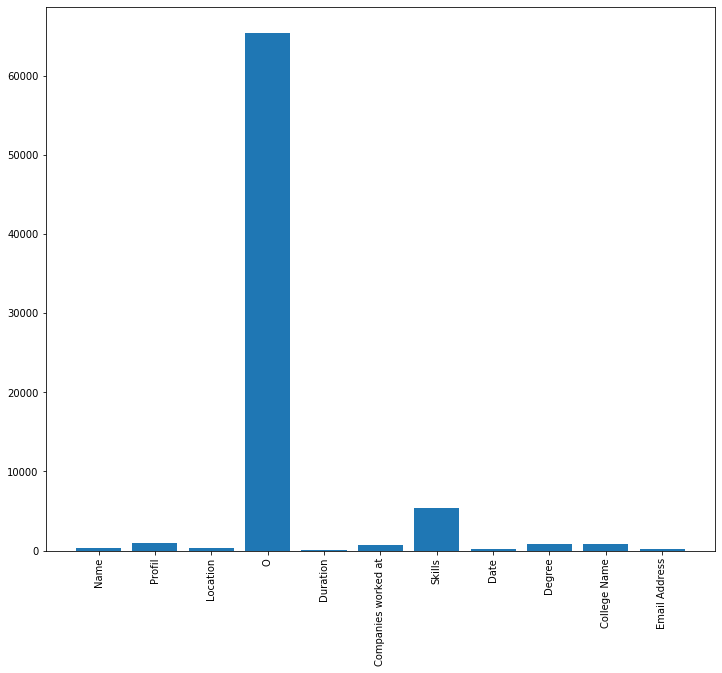

In [2]:
## remove all parenthesis 
#data["Word"] = data["Word"].apply(lambda x :  re.sub(r'[()]*',r'', x))
#data.loc[data.index[data.Word.str.contains("[0-9]{4}$")],'Tag'] = "Year"
data["Tag"].value_counts()

from collections import Counter

occ = Counter(data["Tag"])
occ

plt.xticks(rotation="vertical")
plt.bar(occ.keys(), occ.values())
plt.show()

In [4]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

Using TensorFlow backend.


NameError: name 'X' is not defined

In [7]:
#remove special characters
#data["Word"] = data["Word"].apply(lambda x: re.sub(r'[^\x00-\x7f]',r'', x) )
import math

words = list(set(data["Word"].values))
n_words = len(words)  

# group word by sentence
sentence_columns = []
sentence_number = math.floor(len(data)/25)
remaining = len(data) - sentence_number * 25

for i in range(sentence_number):
    for j in range(25):
        sentence_columns.append(i)
for i in range(remaining):
    sentence_columns.append(sentence_number+1)
    

data['Sentence #'] = sentence_columns
data =  data[["Sentence #","Word","Tag"]]
data

,Sentence #,Word,Tag
0,0,Govardhana,Name
1,0,K,Name
2,0,Senior,Profil
3,0,Software,Profil
4,0,Engineer,Profil
...,...,...,...
75767,3018,Arc,O
75768,3018,"sight,",O
75769,3018,HP,O
75770,3018,Service,O


In [8]:
## remove random O-Tag
import random
import math

index = data.index[data['Tag'] == "O"]
O_tagSize = math.ceil((len(index)*0.6))

#drop_indices = np.random.choice(index, O_tagSize, replace=False)
#data = data.drop(drop_indices)
print(len(data))
data["Tag"].value_counts()



75430


O                      65416
Skills                  5376
Profil                  1006
College Name             880
Degree                   807
Companies worked at      753
Name                     342
Location                 336
Email Address            235
Date                     170
Duration                 109
Name: Tag, dtype: int64

In [5]:
len(data["Word"])

75430

In [9]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)

In [10]:
sent = getter.get_next()
print(sent)
sentences = getter.sentences


[('2', 'Duration'), ('Month', 'Duration'), ('Core', 'Profil'), ('Java', 'Profil'), ('Developer', 'Profil'), ('Languages', 'O'), ('Java,', 'Skills'), ('Go', 'Skills'), ('Lang', 'Skills'), ('Oracle', 'Skills'), ('PL-SQL', 'Skills'), ('programming,', 'O'), ('Sales', 'Profil'), ('Force', 'Profil'), ('Developer', 'Profil'), ('with', 'O'), ('APEX.', 'Skills'), ('Profils', 'O'), ('&', 'O'), ('Promotions', 'O'), ('Willing', 'O'), ('to', 'O'), ('relocate:', 'O'), ('Anywhere', 'O'), ('WORK', 'O')]


In [11]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

In [12]:
X = [sent2features(s) for s in sentences]


y = [sent2labels(s) for s in sentences]

In [13]:
from sklearn.model_selection import train_test_split

train_docs, test_docs, train_labels, test_labels = train_test_split(X, y)

len(train_docs), len(test_docs)


(2263, 755)

In [15]:
%%time
from sklearn_crfsuite import CRF
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

crf.fit(train_docs, train_labels)

Wall time: 16.8 s


C:\Users\Cheikh\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [16]:
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

labels = list(crf.classes_)

labels

y_pred = crf.predict(test_docs)
print(metrics.flat_f1_score(test_labels, y_pred,average='weighted', labels=labels))

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

print(metrics.flat_classification_report(test_labels, y_pred, digits=3))

0.9180301886286756
                     precision    recall  f1-score   support

       College Name      0.520     0.448     0.481       203
Companies worked at      0.729     0.470     0.571       183
               Date      0.643     0.237     0.346        38
             Degree      0.824     0.640     0.720       175
           Duration      0.333     0.074     0.121        27
      Email Address      0.865     0.776     0.818        58
           Location      0.969     0.759     0.851        83
               Name      0.950     0.209     0.342        91
                  O      0.942     0.981     0.961     16720
             Profil      0.746     0.459     0.568       281
             Skills      0.730     0.507     0.598      1016

           accuracy                          0.926     18875
          macro avg      0.750     0.505     0.580     18875
       weighted avg      0.918     0.926     0.918     18875



In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV
import sklearn_crfsuite
import scipy.stats
from sklearn.metrics import make_scorer

# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50, 
                        scoring=f1_scorer)
rs.fit(train_docs, train_labels)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.9min


In [244]:
import eli5
eli5.show_weights(crf, top=30)

C:\Users\Cheikh\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


From \ To,College Name,Companies worked at,Date,Degree,Duration,Email Address,Location,Name,O,Profil,Skills
College Name,4.255,0.0,1.398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Companies worked at,0.0,2.68,0.0,0.0,0.0,0.0,0.811,0.0,1.1,0.0,-0.107
Date,0.0,0.0,0.0,0.214,0.0,0.0,0.0,0.0,0.143,0.0,0.0
Degree,3.449,0.0,0.0,3.96,0.0,0.0,0.0,0.0,-0.233,0.0,0.0
Duration,0.0,0.0,0.0,0.0,3.013,0.0,0.0,0.0,0.0,0.0,0.0
Email Address,0.0,0.0,0.0,0.0,0.0,2.958,0.0,0.0,0.633,0.0,0.0
Location,0.0,0.0,0.0,0.0,0.0,1.57,0.079,0.0,0.987,0.0,0.0
Name,0.0,0.0,0.0,0.0,0.0,0.0,1.146,3.215,-0.405,2.098,0.0
O,-0.177,0.566,0.027,0.0,0.0,1.043,-0.12,0.0,2.435,0.192,0.0
Profil,0.0,2.446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.456,0.0


In [243]:
crf = CRF(algorithm='lbfgs',
          c1=10,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)


crf.fit(train_docs, train_labels)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=10, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [ ]:
y_pred = crf.predict(test_docs)
metrics.flat_f1_score(test_labels, y_pred,
                      average='weighted', labels=labels)

In [ ]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    test_labels, y_pred, labels=sorted_labels, digits=3
))

In [ ]:
import eli5
eli5.show_weights(crf, top=30)